In [ ]:
%matplotlib inline
#%matplotlib notebook
import gui
from SFG2D.dashboards import MyWidgets
from watchdog.observers import Observer

# Set plot layout
#plt.style.use('seaborn-notebook')
#sns.set_style("white")
#sns.set_style("ticks")
#sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Setup Data and Widget class
ppdData = gui.PumpProbeDashboardData('/home/malte/MeasurmentData/2016/09/07/')
#ffolder = '/home/malte/MeasurmentData/2016/09/07/'
ppWidget = gui.PumpProbeWidget(ppdData)
ppWidget.linkTraitlets()
# load last gui config
ppWidget.load(ppdData.ffolder)
#ppWidget.setupObservers(ppdData)

# Setup file observer
ffolder_observer = Observer()
event_handler = gui.MyHandler()
event_handler.ppdData = ppdData
event_handler.ppWidget = ppWidget
ffolder_observer.schedule(event_handler, ppdData.ffolder, recursive=False)
ffolder_observer.start()

## IR Profile

In [2]:
w_ir = MyWidgets.DataImporter(ppdData.ffolder, ppWidget.ir_fpath, 
                           ppWidget.fbase, ppWidget.ir_ppdelay, 
                           ppWidget.ir_spec, ppWidget.ir_sub_base)
w_ir(title='IR Profile', x_label=r'Wavenumbers in 1/cm', y_label='Counts')

/home/malte/Analysis/SFG2D/io/veronica.py:261: UserWarning: cant determine spectrum type of data by filename.Trying to determine datatype from content.This is much slower
  warnings.warn('cant determine spectrum type of data by filename.'


In [3]:
w_ir.save()

TypeError: 'method' object is not iterable

In [ ]:
ppdData.ir = '/19_sp_d20_w675_gcm_e20m_ssp_pu1_pr0_vis1_gal1_chop1_purge1.dat'
ppdData.ir.df["spec_0"].clip_upper(340).plot.hist(bins=np.arange(260, 300, 2))
ppdData.ir.df["spec_1"].clip_upper(340).plot.hist(bins=np.arange(260, 300, 2), alpha=0.5)

## Pump Profile

In [14]:
ppdData._pump = SFG2D.io.veronica.read_auto(ppdData.ffolder + "/07_ts_gold_w575_g1_e1s_ssp_pu1_pr1_vis1_gal1_chop1_purge1.dat")
ppdData.pump.med.ix[0]["spec_0"]

wavenumber
4268.2    303
4269.2    302
4270.1    302
4271.1    299
4272.0    301
4272.9    300
4273.9    301
4274.8    301
4275.8    306
4276.7    305
4277.7    305
4278.6    302
4279.6    298
4280.5    303
4281.5    304
4282.4    304
4283.4    302
4284.3    297
4285.3    304
4286.2    298
4287.2    302
4288.1    299
4289.1    304
4290.0    296
4291.0    303
4291.9    303
4292.8    300
4293.8    298
4294.7    299
4295.7    300
         ... 
5899.3    309
5900.5    305
5901.6    301
5902.7    299
5903.9    303
5905.0    297
5906.2    302
5907.3    300
5908.5    299
5909.6    301
5910.7    303
5911.9    304
5913.0    301
5914.2    300
5915.3    304
5916.5    300
5917.6    305
5918.7    301
5919.9    303
5921.0    297
5922.2    301
5923.3    304
5924.5    305
5925.6    301
5926.7    299
5927.9    301
5929.0    301
5930.2    303
5931.3    302
5932.5    301
Name: spec_0, dtype: int16

In [3]:
w_pump = MyWidgets.DataImporter(ppdData.ffolder, ppWidget.pump_fpath, 
                           ppWidget.pump_fbase, ppWidget.pump_ppdelay, 
                           ppWidget.pump_spec, ppWidget.pump_sub_base)

w_pump(title='Pump-Vis SFG', x_label=r'Wavenumbers in 1/cm', y_label='Counts')

/home/malte/Analysis/SFG2D/io/veronica.py:261: UserWarning: cant determine spectrum type of data by filename.Trying to determine datatype from content.This is much slower
  warnings.warn('cant determine spectrum type of data by filename.'


# Pump-Probe Data

In [4]:
%matplotlib inline
from SFG2D.dashboards import MyWidgets
import gui

ppdData = gui.PumpProbeDashboardData('/home/malte/MeasurmentData/2016/09/07/')
ppWidget = gui.PumpProbeWidget(ppdData)
ppWidget.linkTraitlets()
# load last gui config
ppWidget.load(ppdData.ffolder)
w_pump_probe = MyWidgets.PumpProbeDataImporter(
    ppdData.ffolder, ppWidget.ts0_fpath, 
    ppWidget.fbase, ppWidget.ts0_ppdelay, 
    ppWidget.ts0_pumped, ppWidget.ts0_probed, ppWidget.pump_sub_base,
    ppWidget.ts0_normalize, norm_scan = w_ir.data
)

w_pump_probe(title='Pump Probe Data', x_label='Wavenumbers in 1/cm', y_label='Counts')

/home/malte/Analysis/SFG2D/io/veronica.py:261: UserWarning: cant determine spectrum type of data by filename.Trying to determine datatype from content.This is much slower
  warnings.warn('cant determine spectrum type of data by filename.'


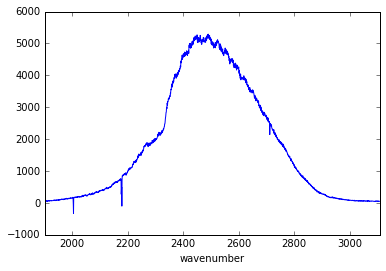

In [7]:
w_pump_probe.scan.norm.plot()


In [7]:
def see(*args):
    if args[0]['owner'] is w_pump_probe.normalise_toggle:
        print('jep')

In [8]:
w_pump_probe.normalise_toggle.observe(see, 'value')

In [4]:
w_pump_probe.normalise_toggle

{'name': 'value', 'new': True, 'owner': <ipywidgets.widgets.widget_bool.ToggleButton object at 0x7f8e6cac25f8>, 'type': 'change', 'old': False}
{'name': 'value', 'new': False, 'owner': <ipywidgets.widgets.widget_bool.ToggleButton object at 0x7f8e6cac25f8>, 'type': 'change', 'old': True}
jep
{'name': 'value', 'new': True, 'owner': <ipywidgets.widgets.widget_bool.ToggleButton object at 0x7f8e6cac25f8>, 'type': 'change', 'old': False}
jep


In [5]:
w_pump_probe.normalise_toggle.description

'Normalize'

In [32]:
a = w_pump_probe.fig.axes[0]
m = w_pump_probe.fig.marks[0]
sx = m.scales['y']
sx.

{}

In [42]:
w_pump_probe.fig.scale_x.min
w_pump_probe.fig

## Baseline for Pump-Probe Data

In [2]:
class w_base():
    data = None
    def get(fbase):
        ppdData._base = SFG2D.io.veronica.read_auto(fbase)
        w_base.data = ppdData.base.med
    
    def update(new):
        w_base.get(ppdData.ffolder + ppWidget.fbase.value)
        
    def fig_init(param_dict={}):
        """Init an empty bqplot figure"""
        x_sc = LinearScale()
        y_sc = LinearScale()

        line = Lines(scales={'x':x_sc, 'y':y_sc})

        ax_x = Axis(scale=x_sc, 
                    label='Wavenumber')
        ax_y = Axis(scale=y_sc, 
                    label='Counts', orientation='vertical')

        fig = Figure(marks=[line], axes=[ax_x, ax_y], 
                     title='Pump Profile')
        return fig
        
    def fig_update(new):
        base_fig.marks[0].x = w_base.data.index
        base_fig.marks[0].y = w_base.data.transpose()
        
w_base.get(ppdData.ffolder + ppWidget.fbase.value)      
base_fig = w_base.fig_init()
w_base.fig_update(None)

ppWidget.fbase.observe(w_base.update, 'value')
ppWidget.fbase.observe(w_base.fig_update, 'value')
#w_base = ipyw.interactive(set_base, fbase = ppWidget.fbase)

display(ppWidget.fbase, base_fig)

/home/malte/Analysis/SFG2D/io/veronica.py:261: UserWarning: cant determine spectrum type of data by filename.Trying to determine datatype from content.This is much slower
  warnings.warn('cant determine spectrum type of data by filename.'


In [ ]:
D = ppdData.ts0.df.sum(level="pp_delay")

dshape = D[ppWidget.ts0_probed.value].shape
D

In [ ]:
class w_pump_probe():
    def get(fpath):
        ppdData.ts0 = SFG2D.io.veronica.read_auto(ppdData.ffolder + fpath)
        if ppWidget.ts0_sub_base.value:
            ppdData.ts0.base = ppdData.base.med
            ppdData.ts0.sub_base(inplace=True)
        if ppWidget.ir_spec.value is "All":
            ppdData.ts0.norm = ppdData.ir.med
        else:
            ppdData.ts0.norm = ppdData.ir.med[ppWidget.ir_spec.value]
        ppdData.ts0u = ppdData.ts0.__deepcopy__()
        
        if ppWidget.ts0_normalize.value:
            ppdData.ts0.normalize(inplace=True)
        ppWidget.ts0_ppdelay.options = list(ppdData.ts0.pp_delays)
        
        if ppWidget.ts0_ppdelay.value not in list(ppdData.ts0.pp_delays):
            ppWidget.ts0_ppdelay.value = ppWidget.ts0_ppdelay.options[0]
        
    def update(new):
        w_pump_probe.get(ppWidget.ts0_fpath.value)
        
    def pump_update(new):
        ppdData.ts0.pumped = ppWidget.ts0_pumped.value
        ppdData.ts0u.pumped = ppWidget.ts0_pumped.value
    
    def probe_update(new):
        ppdData.ts0u.probed = ppWidget.ts0_probed.value
        ppdData.ts0.probed = ppWidget.ts0_probed.value  
        
    def fig_init():
        #bplt.figure(pump_probe_fig)
        D = ppdData.ts0.med.ix[ppWidget.ts0_ppdelay.value]
        bplt.plot(D.index, D.transpose())
        
    def fig_sum_init(): 
        #bplt.figure(pump_probe_sum_fig)
        D = ppdData.ts0._df.sum(level='pp_delay')
        
        bplt.plot(D[ppWidget.ts0_probed.value].as_matrix().flatten('f'))
        bplt.plot(D[ppWidget.ts0_pumped.value].as_matrix().flatten('f'))
        
        dshape = D[ppWidget.ts0_probed.value].shape
        if len(dshape) > 1:
            for i in range(dshape[1]):
                bplt.vline(i * dshape[0])
        
    def fig_pump_probe_update(new):
        #bplt.figure(pump_probe_fig)
        pump_probe_fig.marks[0].x = ppdData.ts0.med.ix[ppWidget.ts0_ppdelay.value].index
        pump_probe_fig.marks[0].y = ppdData.ts0.med.ix[ppWidget.ts0_ppdelay.value].transpose()
        
    def fig_pump_probe_sum_update(new):
        #bplt.figure(pump_probe_sum_fig)
        D = ppdData.ts0._df.sum(level='pp_delay')
        mpr = D[ppWidget.ts0_probed.value].as_matrix().flatten('f')
        mpu = D[ppWidget.ts0_pumped.value].as_matrix().flatten('f')
        pump_probe_sum_fig.marks[0].x = range(mpr.shape[0])
        pump_probe_sum_fig.marks[0].y = (mpr, mpu)
        
        # Delete old vlines and replace with new ones
        pump_probe_sum_fig.marks = [pump_probe_sum_fig.marks[0]]
        dshape = D[ppWidget.ts0_probed.value].shape
        if len(dshape) > 1:
            for i in range(dshape[1]):
                bplt.vline(i * dshape[0])
        
display(ppWidget.ts0_fpath, ppWidget.ts0_probed, ppWidget.ts0_pumped, ppWidget.ts0_ppdelay)

w_pump_probe.get(ppWidget.ts0_fpath.value)
pump_probe_fig = bplt.figure()
w_pump_probe.fig_init()

pump_probe_sum_fig = bplt.figure()
w_pump_probe.fig_sum_init()

ppWidget.ts0_fpath.observe(w_pump_probe.update, 'value')
ppWidget.ts0_fpath.observe(w_pump_probe.fig_pump_probe_update, 'value')
ppWidget.ts0_fpath.observe(w_pump_probe.fig_pump_probe_sum_update, 'value')

#ppWidget.ts0_probed.observe(w_pump_probe.probe_update, 'value')
#ppWidget.ts0_probed.observe(w_pump_probe.fig_pump_probe_update, 'value')

#ppWidget.ts0_pumped.observe(w_pump_probe.pump_update, 'value')
#ppWidget.ts0_pumped.observe(w_pump_probe.fig_pump_probe_update)

#ppWidget.ts0_ppdelay.observe(w_pump_probe.fig_pump_probe_update, 'value')



bplt.show()

In [ ]:
ppdData.ts0

In [ ]:
w_pump_probe.get(ppWidget.ts0_fpath.value)
D = ppdData.ts0._df.sum(level='pp_delay')['spec_0']
len(D.shape)

#### pump_probe_fig = bplt.figure()
w_pump_probe.fig_init()

ppWidget.ts0_fpath.observe(w_pump_probe.update, 'value')
#ppWidget.ts0_fpath.observe(w_pump_probe.fig_pump_probe_sum_update, 'value')
ppWidget.ts0_fpath.observe(w_pump_probe.fig_pump_probe_update, "value")

ppWidget.ts0_probed.observe(w_pump_probe.probe_update, 'value')
ppWidget.ts0_probed.observe(w_pump_probe.fig_pump_probe_update, 'value')

ppWidget.ts0_pumped.observe(w_pump_probe.pump_update, 'value')
ppWidget.ts0_pumped.observe(w_pump_probe.fig_pump_probe_update)

In [ ]:
ppWidget.ts0_fpath

In [ ]:
def set_pump_probe(fpath, sub_base=False, normalize=False):
    ppdData.ts0 = SFG2D.io.veronica.read_auto(ppdData.ffolder + fpath)
    if sub_base:
        ppdData.ts0.base = ppdData.base.med
        ppdData.ts0.sub_base(inplace=True)
    if ppWidget.ir_spec.value is "All":
        ppdData.ts0.norm = ppdData.ir.med
    else:
        ppdData.ts0.norm = ppdData.ir.med[ppWidget.ir_spec.value]
    ppdData.ts0u = ppdData.ts0.__deepcopy__()
    if normalize:
        ppdData.ts0.normalize(inplace=True)
    ppWidget.ts0_ppdelay.options = list(ppdData.ts0.pp_delays)
    ppWidget.ts0_ppdelay.value=0
    
def ts0_pump_update(*args):
    #global ts0
    ppdData.ts0.pumped = ppWidget.ts0_pumped.value
    ppdData.ts0u.pumped = ppWidget.ts0_pumped.value
    
def ts0_probe_update(*args):
    #global ts0
    ppdData.ts0u.probed = ppWidget.ts0_probed.value
    ppdData.ts0.probed = ppWidget.ts0_probed.value
    
def pump_probe_sum_plot(*args):
    ax = axes_pump_probe_get[1]
    if isinstance(ppdData.ts0u, SFG2D.core.scan.TimeScan):
        [SFG2D.plotting.ts.sum_of_spectra(ppdData.ts0u, spec, ax) for spec in ('spec_0', 'spec_1', 'spec_2')]
    ax.set_title("Sum of Spectra")

def pump_probe_plot(pp_delay):
    ax = axes_pump_probe_get[0]
    ax.clear()
    
    if isinstance(ppdData.ts0u, SFG2D.core.scan.TimeScan):
        ppdData.ts0u.med.ix[pp_delay].plot(ax=ax)
        ax.set_title("%i fs"%pp_delay)
        #plt.ylim(-0.002, 0.015) # get this from set_pump_probedata
        #plt.xlim(2100, 2800) # get this from ir profile
    fig_pump_probe_get.tight_layout()
    display(fig_pump_probe_get)

In [ ]:
fig_pump_probe_get, axes_pump_probe_get = plt.subplots(1,2, figsize=(16,6))

ppWidget.ts0 = ipyw.interactive(set_pump_probe, fpath=ppWidget.ts0_fpath, sub_base=ppWidget.ts0_sub_base, normalize=ppWidget.ts0_normalize)
ppWidget.ts0_pumped.observe(ts0_pump_update, 'value')
ppWidget.ts0_probed.observe(ts0_probe_update, 'value')
pp


ppWidget.ts0_plot = ipyw.interactive(pump_probe_plot, pp_delay=ppWidget.ts0_ppdelay)
display(ppWidget.ts0, ppWidget.ts0_pumped, ppWidget.ts0_probed, ppWidget.ts0_plot)
pump_probe_sum_plot()

## Normalize Spectra

In [ ]:
%%capture
fig_norm, ax_norm = plt.subplots(1,2, figsize=(12,6))
ax_norm[0].set_title("Unnormalized")
ax_norm[1].set_title("Normalized")
#ax_norm[1].set_ylim(-0.002, 0.015)
ppdData.ts0u.pumped.ix[ppWidget.ts0_ppdelay.value].plot(ax = ax_norm[0], label="pumped")
ppdData.ts0u.probed.ix[ppWidget.ts0_ppdelay.value].plot(ax = ax_norm[0], label="probed")

ppdData.ts0.pumped.ix[ppWidget.ts0_ppdelay.value].plot(ax = ax_norm[1], label = "pumped")
ppdData.ts0.probed.ix[ppWidget.ts0_ppdelay.value].plot(ax = ax_norm[1], label = "probed")

ax_norm[0].legend()
fig_norm.tight_layout()


def plot_norm_update(pp_delay):
    ax_norm[0].lines[0].set_ydata(ppdData.ts0u.pumped.ix[pp_delay])
    ax_norm[0].lines[1].set_ydata(ppdData.ts0u.probed.ix[pp_delay])

    ax_norm[1].lines[0].set_ydata(ppdData.ts0.pumped.ix[pp_delay])
    ax_norm[1].lines[1].set_ydata(ppdData.ts0.probed.ix[pp_delay])
       
    display(fig_norm)

In [ ]:
ipyw.interact(plot_norm_update, pp_delay=ppWidget.ts0_ppdelay_childs[0])

# Spectra Over Time

In [ ]:
%%capture
roi = slice(2200,2800)

def plot_compare_update(pp_delay):
    for i in range(ppdData.ts0.df['spec_0'].shape[1]):
        data = ppdData.ts0.df.loc[ppWidget.ts0_ppdelay_childs[1].value, "spec_0"][roi].iloc[:,i]
        ax_compare[0].lines[i].set_ydata(data)
        data = ppdData.ts0.df.loc[ppWidget.ts0_ppdelay_childs[1].value, "spec_1"][roi].iloc[:,i]
        ax_compare[1].lines[i].set_ydata(data)
    
    display(fig_compare)
    

fig_compare, ax_compare = plt.subplots(1, 2, sharey=True, figsize=(16,6))
ppdData.ts0.df.loc[ppWidget.ts0_ppdelay_childs[1].value, "spec_0"][roi].plot(ax=ax_compare[0])        
ppdData.ts0.df.loc[ppWidget.ts0_ppdelay_childs[1].value, "spec_1"][roi].plot(ax=ax_compare[1])
for ax, title in zip(ax_compare, ('spec_0', 'spec_1')):
    ax.set_title(title)
    for i in range(len(ax.lines)):
        ax.lines[i].set_label('run %i'%i)
    ax.legend()
#plt.ylim(-0.002, 0.017)

In [ ]:
w_f0 = ipyw.interact(plot_compare_update, pp_delay=ppWidget.ts0_ppdelay_childs[1])
#display(w_f0)

## Smoothed

In [ ]:
#pp_slider3 = ipyw.SelectionSlider(options=list(ppdData.ts0.pp_delays), value=0, continuous_update=False)
roi = slice(2200,2800) # get this from the pump
def p3(pp_delay):
    ppdData.ts0.pumped.loc[pp_delay][roi].rolling(10).mean().plot(label="pumped")
    ppdData.ts0.probed.loc[pp_delay][roi].rolling(10).mean().plot(label="probed")
    #plt.ylim(0.001, 0.015)
    plt.title(str(pp_delay) + " fs")
    plt.legend()
    #plt.grid()

ppWidget.p3 = ipyw.interactive(p3, pp_delay=ppWidget.ts0_ppdelay_childs[2])
display(ppWidget.p3)
plt.show()

# Bleach Trace

In [ ]:
roi_slider_range = int(ppdData.ts0.df.index.levels[1].min()), int(ppdData.ts0.df.index.levels[1].max())
#roi_slider_range = 0, 800
roi_slider = ipyw.IntRangeSlider(
    value = (2450, 2600),
    min = roi_slider_range[0],
    max = roi_slider_range[1],
    continuous_update=False
)

#roi = slice(2450,2600)

def plot_bleach_trace(roi):
    tss = ppdData.ts0.bleach.unstack(0)
    tss = tss[(tss.index > roi[0]) & (tss.index < roi[1])].sum()

    tss.plot()
    plt.scatter(tss.index, tss)
    plt.title(r"Bleach from (%i to %i)cm$^{-1}$"%(roi[0], roi[1]))
    
ipyw.interact(plot_bleach_trace, roi=roi_slider)
plt.show()

In [ ]:
ppdData.ts0.pump

In [ ]:
ppdData.ts0.df.ix[0, "spec_0"].plot()

In [ ]:
import datetime
pp_delays = 25
exp_time = 10# in minutes
reps = 3 #number of repetitions
datetime.datetime.now() + datetime.timedelta(minutes=pp_delays*exp_time*reps)

In [ ]:
25*10/60